# Surface Bencharking of External Aero Flows

In this notebook we will walk through the steps required for generating a sample model inference on simulation mesh and compare the model's predictions with the ground truth data across several metrics relevant to the external aerodynamics. This notebook uses the surface results from the [DrivAerML dataset](https://caemldatasets.org/drivaerml/). More specifically, we will use the `202` sample ID to compute all the metrics and comparisons.  

## Compute model inference on the benchmark simulation

The benchmark results are saved in `.vtp` and `.vtu` formats for the surface and volume results respectively. For this notebook, let's start with loading up the `.vtp` file and investigating the fields present in it. We will use the [`pyvista`](https://pyvista.org/) library for this purpose.

### Download the benchmark solution

Let's download the solution from the [DrivAerML dataset](https://huggingface.co/datasets/neashton/drivaerml).

In [1]:
import os

filenames = [
    "drivaer_202.stl",
    "boundary_202.vtp",
]
urls = [
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/drivaer_202.stl",
    "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/boundary_202.vtp",
]

for filename, url in zip(filenames, urls):
    if not os.path.exists(filename):
        !wget "{url}" -O "{filename}"
    else:
        print(f"{filename} already exists. Skipping download.")

--2025-07-31 18:11:26--  https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_202/drivaer_202.stl
Resolving huggingface.co (huggingface.co)... 3.168.86.127, 3.168.86.52, 3.168.86.96, ...
Connecting to huggingface.co (huggingface.co)|3.168.86.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/93/df/93dfb6ee50706b5fa0c20b5690e6004518cf8134d987715d3993e31be151f708/517ef257d4cd84b429a2407bdc49332fdcc6623cf32c534e78542ebda3baebcb?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27drivaer_202.stl%3B+filename%3D%22drivaer_202.stl%22%3B&response-content-type=model%2Fstl&Expires=1753989086&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1Mzk4OTA4Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzkzL2RmLzkzZGZiNmVlNTA3MDZiNWZhMGMyMGI1NjkwZTYwMDQ1MThjZjgxMzRkOTg3NzE1ZDM5OTNlMzFiZTE1MWY3MDgvNTE3ZWYyNTdkNGNkODRiNDI5YTI0MDdiZGM0OTMzMmZkY2M2NjIzY2YzMmM1Mz

In [2]:
import pyvista as pv

mesh = pv.read("./boundary_202.vtp")
mesh

PolyData (0x7d2396cf5cc0)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   5

We observe that the mesh contains `8902069` points and `8883343` cells. The pressure and wall shear stress variables are stored as `pMeanTrim` and `wallShearStressMeanTrim`. Let's write the model's predictions as `pMeanTrimPred` and `wallShearStressMeanTrimPred`. We will compute the inference using the [DoMINO Automotive-Aero NIM](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/overview.html), but one can easily adapt the code to suit the specific model input outputs. Make sure to start the NIM container following the instructions [here](https://docs.nvidia.com/nim/physicsnemo/domino-automotive-aero/latest/quickstart-guide.html).

---
**NOTE**

If you are using the Docker container for running this notebook (eg. the [PhysicsNeMo Docker container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/physicsnemo/containers/physicsnemo)), ensure that you start both the NIM container and the Docker container for this notebook with `--network host` flag, so that the container running the notebook can communicate with the NIM container.

---

---
**IMPORTANT**

We are using the DrivAerML dataset with the DoMINO NIM for this example. The DoMINO NIM is trained on RANS data, while the DrivAerML dataset is generated using RANS-LES (HRLES) simulations. The results from the DoMINO NIM can thus suffer from inaccuracies in the prediction of turbulent quantities (e.g. Turbulent Viscosity and Wall Shear Stress) when compared to the ground truth (HRLES) data. To refer the true performance of DoMINO model architecture, trained on the DrivAerML dataset, please refer to the [Using standardized datasets for inter-model comparison section from README.md](../README.md#using-standardized-datasets-for-inter-model-comparisons).

---


In [3]:
# Convert the multi-body STL to a single STL
import numpy as np
import os, time
from physicsnemo.cfd.bench.interpolation.interpolate_mesh_to_pc import (
    _create_nbrs_surface,
    _interpolate,
)
from physicsnemo.cfd.inference.domino_nim import call_domino_nim

output_dict = call_domino_nim(
    stl_path="./drivaer_202.stl",
    inference_api_url="http://localhost:8000/v1/infer",
    data={
        "stream_velocity": "38.89",
        "stencil_size": "1",
        "point_cloud_size": "500000",
    },
    verbose=True,
)
print("Interpolating results on the benchmarking mesh...")

# Interpolate the results of the NIM onto the mesh points
# v2 of NIM will enable inference on custom point clouds, so this step will not be required in future
start_time = time.time()
mesh_cell_centers = mesh.cell_centers()
nbrs_surface = _create_nbrs_surface(
    output_dict["surface_coordinates"][0, :], device="gpu"
)
fields = np.concatenate(
    [output_dict["pressure_surface"][0, :], output_dict["wall_shear_stress"][0, :]],
    axis=1,
)
fields_interp = _interpolate(
    nbrs_surface, mesh_cell_centers.points, fields, device="gpu", batch_size=10_000_000
)
mesh.cell_data["pMeanTrimPred"] = fields_interp[:, 0]
mesh.cell_data["wallShearStressMeanTrimPred"] = fields_interp[:, 1:4]
print(f"Interpolation took {time.time() - start_time:.3f} sec")

mesh

Sending POST request to DoMINO NIM inference API at http://localhost:8000/v1/infer...
Inference complete. Output keys: dict_keys(['sdf', 'coordinates', 'velocity', 'pressure', 'turbulent_kinetic_energy', 'turbulent_viscosity', 'bounding_box_dims', 'surface_coordinates', 'pressure_surface', 'wall_shear_stress', 'drag_force', 'lift_force']).
Interpolating results on the benchmarking mesh...
Interpolation took 10.198 sec


PolyData (0x7d2396cf5cc0)
  N Cells:    8883343
  N Points:   8902069
  N Strips:   0
  X Bounds:   -9.240e-01, 3.886e+00
  Y Bounds:   -1.061e+00, 1.061e+00
  Z Bounds:   -3.176e-01, 1.074e+00
  N Arrays:   7

Now that we have both the predicted and true fields on the same points (cell centers to be precise), we can start with comparing these two solutions.

## L2 Errors

Let's compare the L2 errors for the pressure and the wall shear stress fields. We will use the `compute_l2_errors` function from the library. 

In [4]:
from physicsnemo.cfd.bench.metrics.l2_errors import compute_l2_errors

l2_errors = compute_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    dtype="cell",
)
l2_errors

{'pMeanTrim_l2_error': np.float64(0.4190319335052403),
 'wallShearStressMeanTrim_x_l2_error': np.float64(0.6831535812319535),
 'wallShearStressMeanTrim_y_l2_error': np.float64(0.8277238523713482),
 'wallShearStressMeanTrim_z_l2_error': np.float64(0.7445107671102597)}

This gives a numeric comparison of the model's overall performance.

The meshes are typically refined with smaller triangles in the areas with high geometric detail. We can compute the area-weighted l2 erros to see how the L2 errors relate to the size of the cells by using `compute_area_weighted_l2_errors`. Note, this metric only works for `cell` dtype. 

In [5]:
from physicsnemo.cfd.bench.metrics.l2_errors import compute_area_weighted_l2_errors

area_weighted_l2_errors = compute_area_weighted_l2_errors(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    dtype="cell",
)
area_weighted_l2_errors

{'pMeanTrim_area_wt_l2_error': np.float64(0.3347586634823654),
 'wallShearStressMeanTrim_x_area_wt_l2_error': np.float64(0.4394475330423934),
 'wallShearStressMeanTrim_y_area_wt_l2_error': np.float64(0.7056855552099212),
 'wallShearStressMeanTrim_z_area_wt_l2_error': np.float64(0.6508000601879518)}

## Computing drag metrics

Drag force is an important consideration for the efficiency and performance of the vehicle. We can use the `compute_drag_and_lift` function to compute the drag and lift coefficient / forces

In [6]:
from physicsnemo.cfd.bench.metrics.aero_forces import compute_drag_and_lift

forces_true = compute_drag_and_lift(
    mesh,
    pressure_field="pMeanTrim",
    wss_field="wallShearStressMeanTrim",
    coeff=1.0,  # Set it to 1.0 to get raw forces. can be replaced 2 / (rho * u * u * ref_area) for coefficients
    drag_direction=[1, 0, 0],
    lift_direction=[0, 0, 1],
    dtype="cell",
)  # retruns F_drag, F_drag_pressure, F_drag_skin_friction, F_lift, F_lift_pressure, F_lift_skin_friction

forces_pred = compute_drag_and_lift(
    mesh,
    pressure_field="pMeanTrimPred",
    wss_field="wallShearStressMeanTrimPred",
    coeff=1.0,  # Set it to 1.0 to get raw forces. can be replaced 2 / (rho * u * u * ref_area) for coefficients
    drag_direction=[1, 0, 0],
    lift_direction=[0, 0, 1],
    dtype="cell",
)  # retruns F_drag, F_drag_pressure, F_drag_skin_friction, F_lift, F_lift_pressure, F_lift_skin_friction

labels = ["Drag Force (D)", "D_p", "D_f", "Lift Force (L)", "L_p", "L_f"]
for label, f_true, f_pred in zip(labels, forces_true, forces_pred):
    print(
        f"{label}: True: {f_true}, Pred: {f_pred}, Error (%): {abs(f_true - f_pred) * 100 / f_true}"
    )

Drag Force (D): True: 482.3444254302631, Pred: 443.4446705427987, Error (%): 8.064725709800594
D_p: True: 435.0610781379878, Pred: 405.62859491485483, Error (%): 6.765138207513454
D_f: True: 47.28334729227524, Pred: 37.816075627943874, Error (%): 20.022422705843518
Lift Force (L): True: 37.28053920122983, Pred: 193.04157490432152, Error (%): 417.8078939854855
L_p: True: 34.24916887927558, Pred: 189.28642974288204, Error (%): 452.67452010323274
L_f: True: 3.03137032195425, Pred: 3.7551451614394797, Error (%): 23.876160370225904


When computing the drag and lift forces for several cases, you can also use the visualization utils like `physicsnemo.cfd.bench.visualization.utils.plot_design_scatter` and `physicsnemo.cfd.bench.visualization.utils.plot_design_trend` to compute metrics such as R2 scores and compare the design trends / measure the abiility of the models to capture directional changes. The workflow scripts ([../generate_surface_benchmarks.py](../generate_surface_benchmarks.py) and [../generate_volume_benchmarks.py](../generate_volume_benchmarks.py)) which are designed to compute these metrics across several samples use these functions to create plots like below:

![Sample R2 score plot](img/design_scatter_plot.png)

![Sample design trend plot](img/design_trend_plot.png)


## Plotting fields

So far, we have seen some numerics which are important for analytical study, however, in a lot of instances, visualizing the flow fields is also important to understand the flow behavior such as areas of flow separation, stagnation points, etc.  

MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
2025-07-31 18:24:14.188 ( 746.497s) [    7D23D9E2B740]vtkXOpenGLRenderWindow.:679   WARN| vtkXOpenGLRenderWindow (0x475200a0): Cannot create GLX context.
2025-07-31 18:24:1

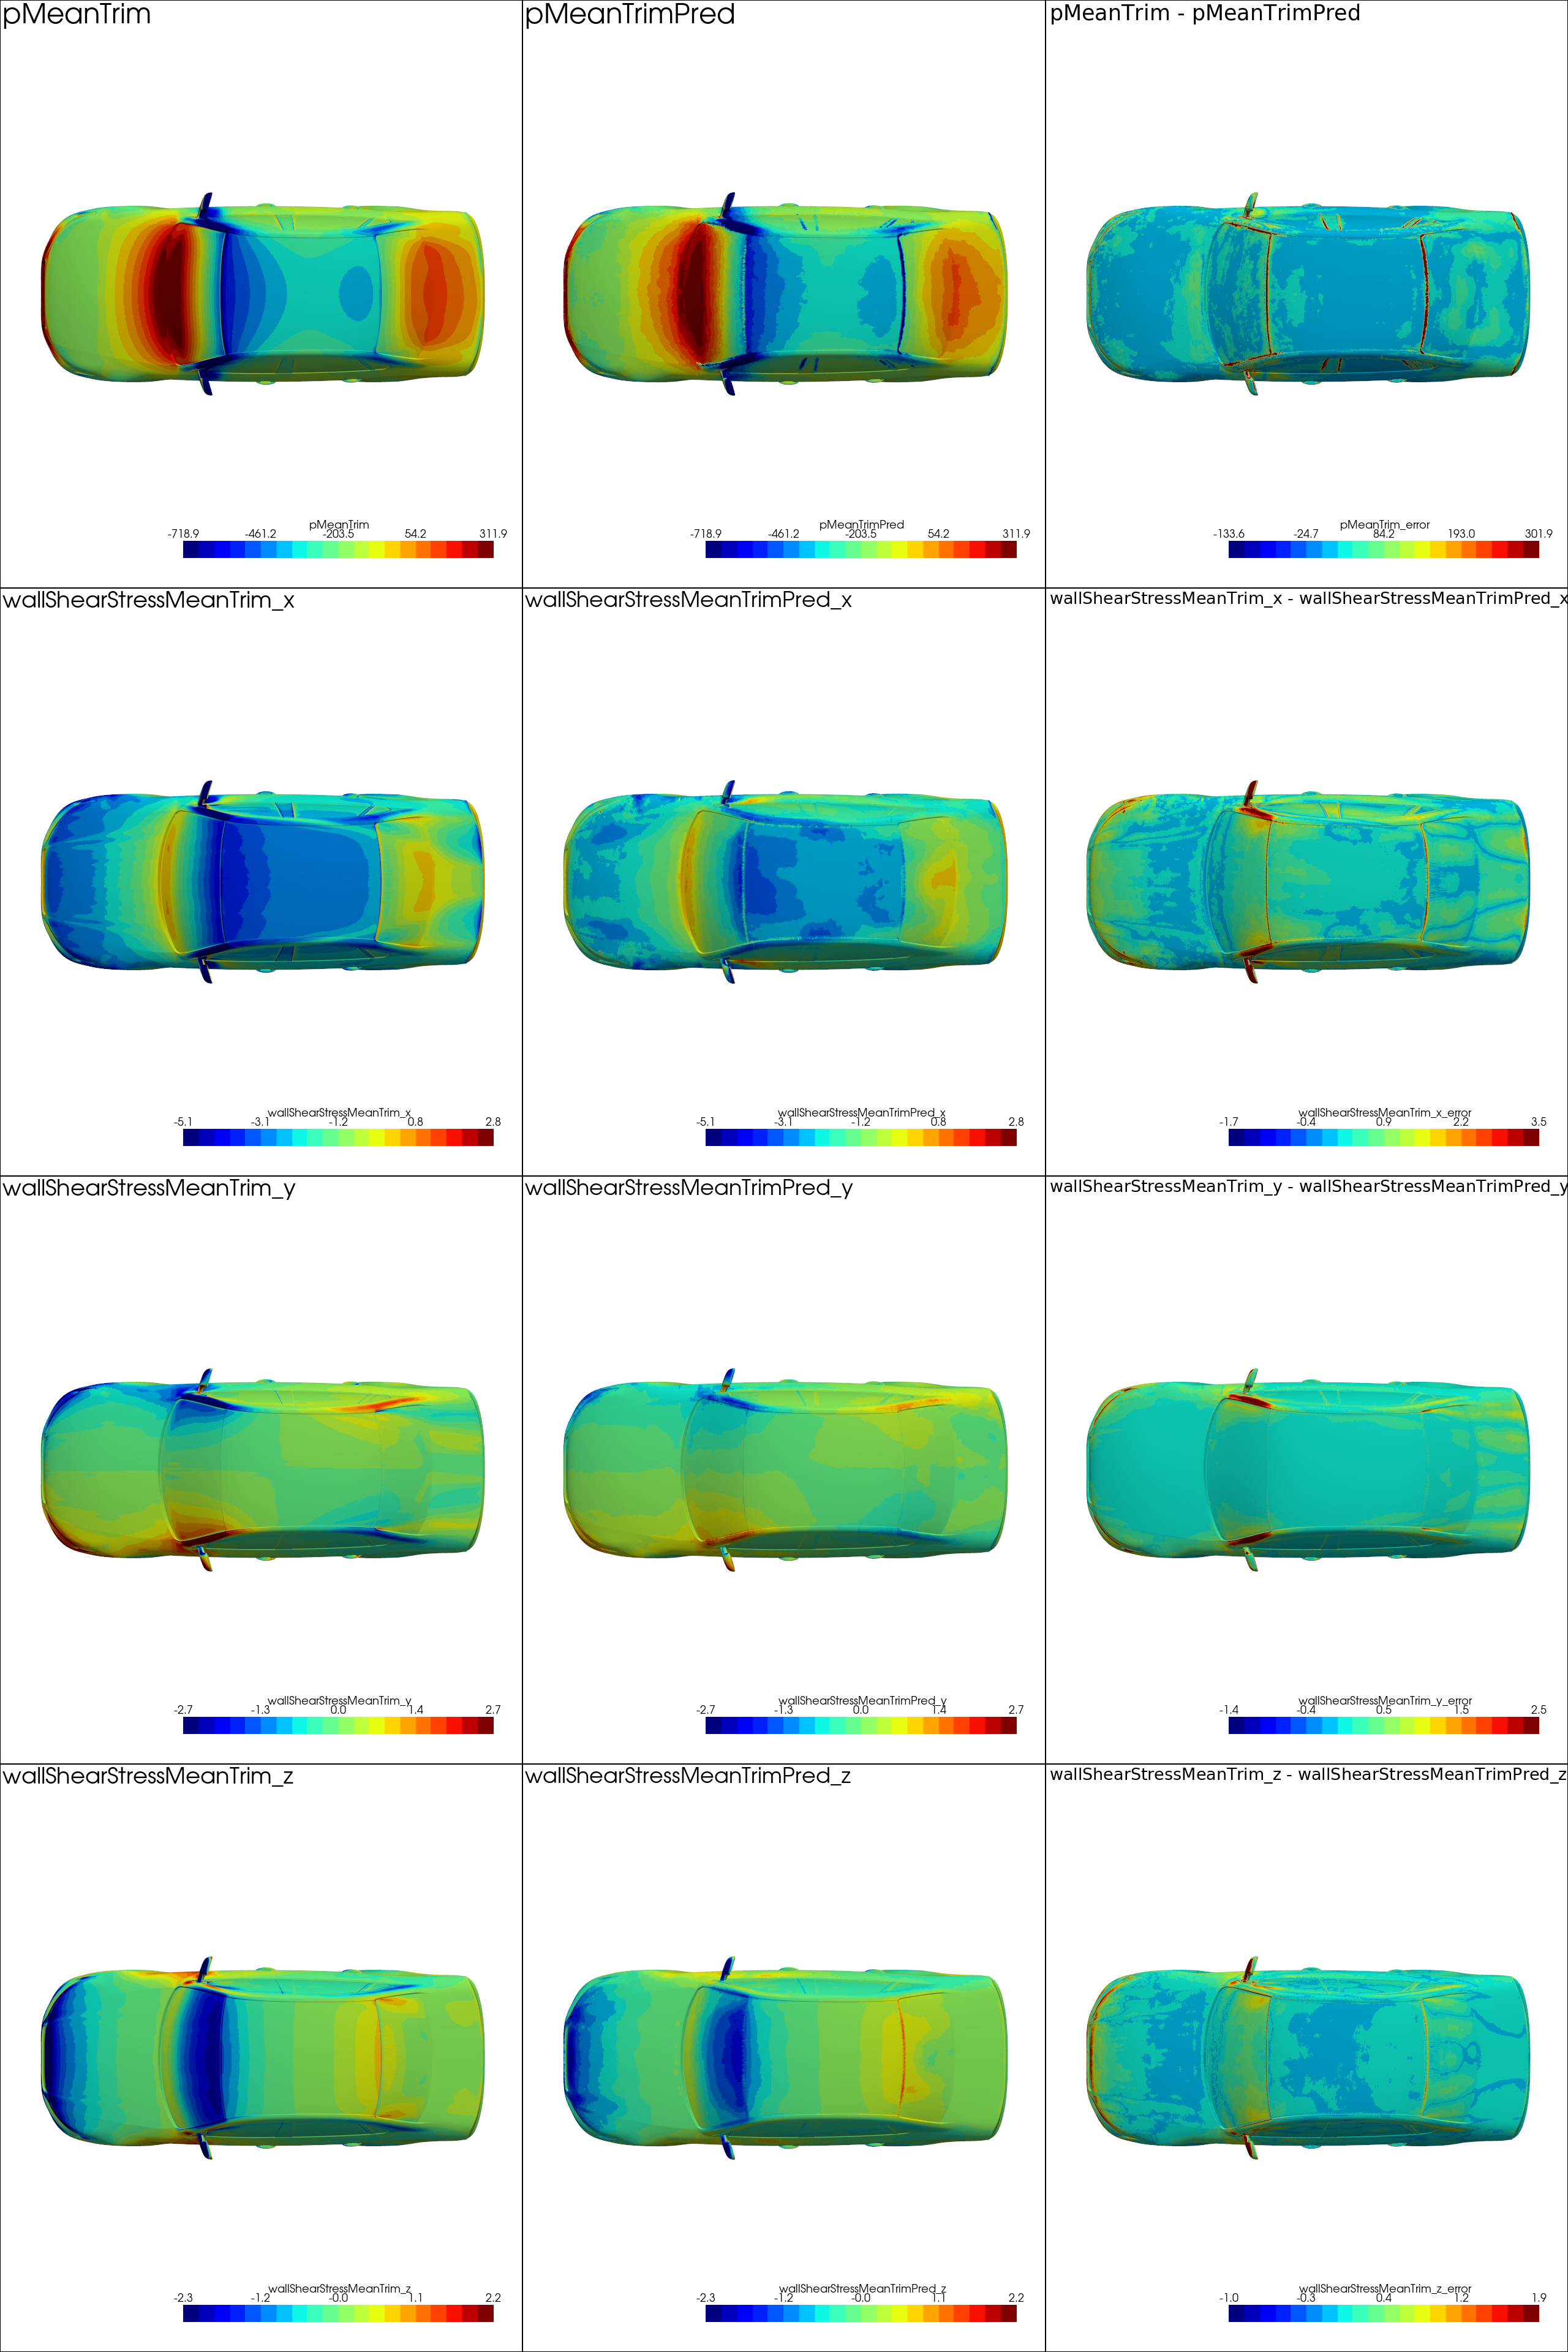

In [8]:
from physicsnemo.cfd.bench.visualization.utils import plot_field_comparisons

pv.start_xvfb()  # might require apt-get install xvfb

plotter = plot_field_comparisons(
    mesh,
    true_fields=["pMeanTrim", "wallShearStressMeanTrim"],
    pred_fields=["pMeanTrimPred", "wallShearStressMeanTrimPred"],
    view="xy",
    plot_vector_components=True,
    cmap="jet",
    lut=20,
)
plotter.screenshot("./sample_202_surface_comparison.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_surface_comparison.png")

The visualization reveals that the AI prediction is able to capture the larger structures in the flow field for most of the variables, except the x component of wall shear stress where it seems to struggle with the flow structures on the hood and the roof of the vehicle. For the other variables, higher errors are observed near the mirrors or sharp edges.

We can also create some line plots for a more detailed visualization and comparison. Here we will plot the pressure along the centerline of the car.

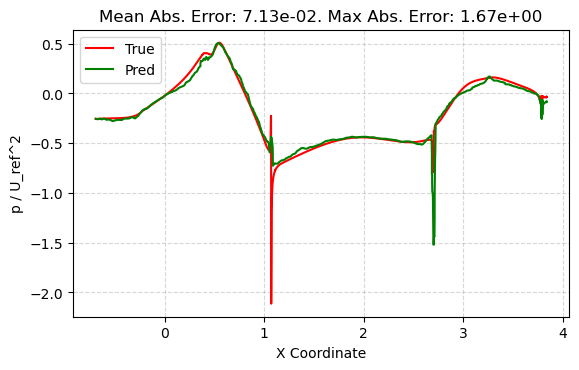

In [9]:
from physicsnemo.cfd.bench.visualization.utils import plot_line

# create a slice along xz plane
centerline = mesh.slice(origin=(0, 0, 0), normal=(0, 1, 0))
centerline = centerline.clip(
    origin=(0, 0, 0.4), normal=(0, 0, 1), invert=False
)  # Select only the top half
centerline = centerline.cell_data_to_point_data(pass_cell_data=True)

fig = plot_line(
    centerline,
    plot_coord="x",
    field_true="pMeanTrim",
    field_pred="pMeanTrimPred",
    normalize_factor=(38.89**2) / 2,
    flip=False,
    xlabel="X Coordinate",
    ylabel="p / U_ref^2",
    true_line_kwargs={"color": "red", "label": "True"},
    pred_line_kwargs={"color": "green", "label": "Pred"},
    figsize=(6, 4),
)

Besides the sharp peaks, the centerline pressure matches well w.r.t. to the ground truth.

Streamlines is yet another way to visualize the flow fields and gain deeper insights in to the flow behavior. For surface results, we can create streamlines of wall shear stress. Below we will create the streamlines using `physicsnemo.cfd.bench.metrics.streamlines.compute_streamlines` function and then plot them. We will overlay the streamlines on the STL of the geometry for better visualization. 

In [10]:
import numpy as np
from physicsnemo.cfd.bench.metrics.streamlines import compute_streamlines
from physicsnemo.cfd.bench.visualization.utils import plot_streamlines

true_streamlines = compute_streamlines(mesh, field="wallShearStressMeanTrim")
pred_streamlines = compute_streamlines(mesh, field="wallShearStressMeanTrimPred")

stl_mesh = pv.read("./drivaer_202.stl")
# Shrink the STL slightly
center = np.array(stl_mesh.center)
scale_factor = 0.999
stl_mesh = stl_mesh.translate(-center).scale(scale_factor).translate(center)

plotter = plot_streamlines(true_streamlines, pred_streamlines, stl_mesh, view="xy")
plotter.screenshot("./sample_202_streamlines.png")

# Display the image
from IPython.display import Image

Image(filename="./sample_202_streamlines.png")

/localhome/local-ktangsali/anaconda3/lib/python3.13/site-packages/pyvista/core/filters/data_set.py:3066: PyVistaDeprecationWarning: ``max_time`` parameter is deprecated.  It will be removed in v0.48
  warnings.warn(


: 

That completes the surface benchmarking notebook. For volume benchmarking, refer [`volume_benchmarking.ipynb`](./volume_benchmarking.ipynb). For running the metrics shown here on a several geometries / cases, refer to [`../generate_surface_benchamrks.py`](../generate_surface_benchmarks.py). 